# Make figure showing pre-processing

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import numpy as np
import numpy
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pink_utils as pu
from scipy.stats import norm

In [2]:
radio = fits.open("../Raw_Images/Example_Sources/first/J140118+061210.fits")
rdata = radio[0].data

wise = fits.open("../Raw_Images/Example_Sources/wise_reprojected/J140118+061210.fits")
wdata = wise[0].data

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


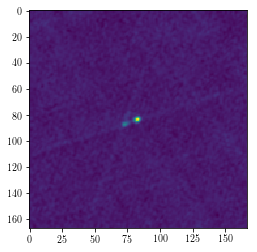

In [3]:
fig, ax = plt.subplots(1,1)

ax.imshow(rdata)

fig.show()

In [4]:
def slice_mask(image, center_size):
    size = image.shape
    empty = np.isnan(image)
    center = (slice(int(size[0]/2-size[0]/center_size), int(size[0]/2+size[0]/center_size)), 
              slice(int(size[1]/2-size[1]/center_size), int(size[1]/2+size[1]/center_size)))
    mask = np.ones(image.shape, np.bool)
    mask[center] = 0
    mask[empty] = 0
    
    return mask

def calculateBackgroundStatistics(image, centerSize):
    size = image.shape
    empty = numpy.isnan(image)
    center = (slice(int(size[0]/2-size[0]/centerSize), int(size[0]/2+size[0]/centerSize)), 
              slice(int(size[1]/2-size[1]/centerSize), int(size[1]/2+size[1]/centerSize)))
    mask = numpy.ones(image.shape, numpy.bool)
    mask[center] = 0
    mask[empty] = 0
    #print (numpy.sum(mask)/128.0/128.0, numpy.count_nonzero(~numpy.isnan(image)))
    backgroundMean = numpy.mean(image[mask])
    backgroundStd = numpy.std(image[mask])
    backgoundMin = numpy.min(image[mask])
    
    return backgroundMean, backgroundStd, backgoundMin

def preprocessImageF3(image, scale):
    empty = numpy.isnan(image)
    mu, sigma, _minimum = calculateBackgroundStatistics(image, 5)
    image[empty] = numpy.random.normal(loc=mu, scale=sigma, size=image.shape)[empty] # replace missing values with noise
#    mu, sigma, minimum = calculateBackgroundStatistics(image, 5)
    image = image - mu
    image = numpy.clip(image, 1.0*sigma, 1e10) # clip background
    image = image - 1.0*sigma
    image = image / numpy.max(image)
    result = image * scale
    
    return result

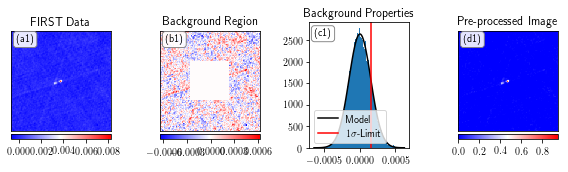

In [73]:
from matplotlib import ticker
def add_cbar(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax0 = divider.append_axes('bottom', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax0, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()

fig, ax = plt.subplots(1,4, figsize=(8, 10/4))

im = ax[0].imshow(rdata, cmap='bwr')
pu.no_ticks(ax[0])
add_cbar(fig, ax[0], im)
ax[0].set(title='FIRST Data')

mask = slice_mask(rdata, 5)
mask_rdata = rdata.copy()
mask_rdata[~mask] = 0

im = ax[1].imshow(mask_rdata, cmap='bwr')
pu.no_ticks(ax[1])
add_cbar(fig, ax[1], im)
ax[1].set(title='Background Region')

mu = np.mean(mask_rdata[mask_rdata != 0].flatten())
std = np.std(mask_rdata[mask_rdata != 0].flatten())

ax[2].hist(mask_rdata[mask_rdata != 0].flatten(), bins=100, density=True, linewidth=0)
xdata_rng = np.linspace(mask_rdata.min(), mask_rdata.max(),100)
ax[2].plot(xdata_rng, norm.pdf(xdata_rng, mu, std), c='black', label='Model')
ax[2].axvline(mu+std, color='red', label='$1\sigma$-Limit')
ax[2].legend(loc='lower left')
ax[2].set(title='Background Properties')

pre_rdata = preprocessImageF3(rdata, 0.95)
im = ax[3].imshow(pre_rdata, cmap='bwr')
pu.no_ticks(ax[3])
add_cbar(fig, ax[3], im)
ax[3].set(title='Pre-processed Image')

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax[0].annotate('(a1)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[1].annotate('(b1)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[2].annotate('(c1)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[3].annotate('(d1)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)

fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_First_Preprocessing.pdf')

In [74]:
def preprocessImageW2(image,scale):
    empty = numpy.isnan(image)
    image[empty] = numpy.random.normal(loc=numpy.mean(image[~empty]), scale=numpy.std(image[~empty]), size=image.shape)[empty]
    image = numpy.clip(image, 0.0001, 1e10)
    #image = image - numpy.min(image) + 0.0001 # equals -5 for log10 :-)
    image = numpy.log10(image)
    #image = numpy.clip(image, -5, 1e10) # clip after the log !
    image = (image - numpy.min(image)) / (numpy.max(image) - numpy.min(image))
    result = image * scale
    return result

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


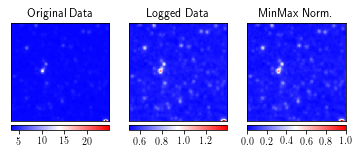

In [75]:
fig, ax = plt.subplots(1,3)

im = ax[0].imshow(wdata, cmap='bwr')
pu.no_ticks(ax[0])
add_cbar(fig, ax[0], im)
ax[0].set(title='Original Data')

log_wdata = numpy.clip(wdata, 0.0001, 1e10)
log_wdata = np.log10(log_wdata)
im = ax[1].imshow(log_wdata, cmap='bwr')
pu.no_ticks(ax[1])
add_cbar(fig, ax[1], im)
ax[1].set(title='Logged Data')


norm_wdata = (log_wdata - np.min(log_wdata)) / (numpy.max(log_wdata) - numpy.min(log_wdata))
im = ax[2].imshow(norm_wdata, cmap='bwr')
pu.no_ticks(ax[2])
add_cbar(fig, ax[2], im)
ax[2].set(title='MinMax Norm.')


fig.show()

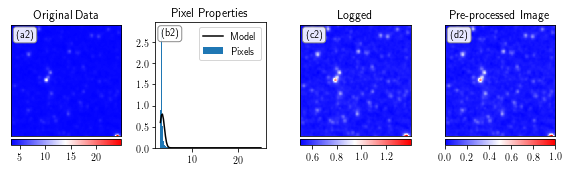

In [76]:
fig, ax = plt.subplots(1,4, figsize=(8, 10/4))

im = ax[0].imshow(wdata, cmap='bwr')
pu.no_ticks(ax[0])
add_cbar(fig, ax[0], im)
ax[0].set(title='Original Data', ylabel='$\\textit{WISE}$')

empty = (np.isnan(wdata)) | (wdata > 30)
mu = np.mean(wdata[~empty].flatten())
std = np.std(wdata[~empty].flatten())
xdata_rng = np.linspace(wdata[~empty].min(), wdata[~empty].max(),100)

ax[1].hist(wdata[~empty].flatten(), bins=100,density=True, label='Pixels')
ax[1].set(title='Pixel Properties')
# ax[1].hist(numpy.clip(wdata, 0.0001, 1e10).flatten(), bins=100)
ax[1].plot(xdata_rng, norm.pdf(xdata_rng, mu, std), c='black', label='Model')
ax[1].legend()
# ax[1].set(xlabel='Intensity')

log_wdata = numpy.clip(wdata, 0.0001, 1e10)
log_wdata = np.log10(log_wdata)
im = ax[2].imshow(log_wdata, cmap='bwr')
pu.no_ticks(ax[2])
add_cbar(fig, ax[2], im)
ax[2].set(title='Logged')

norm_wdata = (log_wdata - np.min(log_wdata)) / (numpy.max(log_wdata) - numpy.min(log_wdata))
im = ax[3].imshow(norm_wdata, cmap='bwr')
pu.no_ticks(ax[3])
add_cbar(fig, ax[3], im)
ax[3].set(title='Pre-processed Image')

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax[0].annotate('(a2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[1].annotate('(b2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[2].annotate('(c2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[3].annotate('(d2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)


fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_Wise_Preprocessing.pdf')

In [77]:
from scipy.stats import lognorm

3.55514711442 3.47041911402 0.496576539404 3.17673827963
24.97650943
1.0


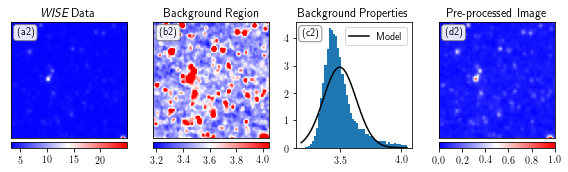

In [79]:
fig, ax = plt.subplots(1,4, figsize=(8, 10/4))
im = ax[0].imshow(wdata, cmap='bwr')
pu.no_ticks(ax[0])
add_cbar(fig, ax[0], im)
ax[0].set(title='$\\textit{WISE}$ Data')

cdata = wdata.copy()
# Clip out bright pixels initially
mu, median, std, dmin = np.mean(cdata), np.median(cdata), np.std(cdata), np.min(cdata)
print(mu,median,std,dmin)

cmask = cdata > mu+std

mu, median, std, dmin = np.mean(cdata[cmask]), np.median(cdata[cmask]), np.std(cdata[cmask]), np.min(cdata[cmask])


empty = (np.isnan(wdata)) | (cmask)
mu = np.mean(wdata[~empty].flatten())
std = np.std(wdata[~empty].flatten())
xdata_rng = np.linspace(wdata[~empty].min(), wdata[~empty].max(),100)

pdata = wdata.copy()
print(pdata.max())
pdata[empty] = np.max(pdata[~empty])
im = ax[1].imshow(pdata, cmap='bwr')
pu.no_ticks(ax[1])
add_cbar(fig, ax[1], im)
ax[1].set(title='Background Region')

# im = ax[2].imshow(log_wdata, cmap='bwr')
# pu.no_ticks(ax[2])
# add_cbar(fig, ax[2], im)
# ax[2].set(title='Logged')

ax[2].hist(wdata[~empty].flatten(), bins=50,density=True, linewidth=0)
ax[2].set(title='Background Properties')
# ax[1].hist(numpy.clip(wdata, 0.0001, 1e10).flatten(), bins=100)
ax[2].plot(xdata_rng, norm.pdf(xdata_rng, mu, std), c='black', label='Model')
ax[2].legend()

log_wdata = numpy.clip(wdata, 0.0001, 1e10)
log_wdata = np.log10(log_wdata)
norm_wdata = (log_wdata - np.min(log_wdata)) / (numpy.max(log_wdata) - numpy.min(log_wdata))
im = ax[3].imshow(norm_wdata, cmap='bwr')
pu.no_ticks(ax[3])
add_cbar(fig, ax[3], im)
ax[3].set(title='Pre-processed Image')

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax[0].annotate('(a2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[1].annotate('(b2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[2].annotate('(c2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)
ax[3].annotate('(d2)', xy=(0.05,0.89), xycoords='axes fraction', bbox=bbox_props)


fig.tight_layout()
# fig.show()
plt.savefig('Images/Figure_Wise_Preprocessing.pdf')
print(norm_wdata.max())